<a href="https://colab.research.google.com/github/stevengregori92/CNN-Intro/blob/main/CNN_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install "jcopdl<2.0"
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
!gdown https://drive.google.com/uc?id=1CYqqgnBqPa6MmFFMbm5NZbPiK1HCYaAf

Downloading...
From: https://drive.google.com/uc?id=1CYqqgnBqPa6MmFFMbm5NZbPiK1HCYaAf
To: /content/CNN_DATA.zip
100% 40.3M/40.3M [00:00<00:00, 134MB/s]


In [9]:
!unzip /content/CNN_DATA.zip

Archive:  /content/CNN_DATA.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/test/
  inflating: data/test/.DS_Store     
   creating: __MACOSX/data/test/
  inflating: __MACOSX/data/test/._.DS_Store  
   creating: data/test/noninvasive/
  inflating: data/test/noninvasive/1637.jpg  
  inflating: data/test/noninvasive/1810.jpg  
  inflating: data/test/noninvasive/1804.jpg  
  inflating: data/test/noninvasive/1838.jpg  
  inflating: data/test/noninvasive/1743.jpg  
  inflating: data/test/noninvasive/1780.jpg  
  inflating: data/test/noninvasive/1794.jpg  
  inflating: data/test/noninvasive/1582.jpg  
  inflating: data/test/noninvasive/1596.jpg  
  inflating: data/test/noninvasive/1597.jpg  
  inflating: data/test/noninvasive/1795.jpg  
  inflating: data/test/noninvasive/1742.jpg  
  inflating: data/test/noninvasive/1839.jpg  
  inflating: data/test/noninvasive/1811.jpg 

#Dataset & Dataloader

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [11]:
bs=128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('data/train', transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle = True, num_workers=4)

test_set = datasets. ImageFolder('data/test', transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [26]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

#Arsitektur dan Config

In [27]:
from jcopdl.layers import conv_block, linear_block

In [28]:
nn.Conv2d(3,8,3,1,1)

Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [29]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv=nn.Sequential(
        conv_block(3, 8),
        conv_block(8, 16),
        conv_block(16, 32),
        conv_block(32, 64),
        nn.Flatten()
    )
    self.fc = nn.Sequential(
        linear_block(1024, 256, dropout=0.1),
        linear_block(256, 2, activation='lsoftmax')
    )

  def forward(self, x):
    x = self.conv(x)
    x = self.fc(x)
    return x

In [30]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size
})

#Training Prepareation

In [31]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='model')

#Training Loop include Acc

In [32]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device) # corrected line
        output = model(feature)
        loss = criterion(output, target)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
        
    cost = cost/len(dataset)
    acc = correct/len(dataset)
    return cost, acc

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6897 | Test_cost  = 0.6761 | Train_score = 0.5240 | Test_score = 0.6725 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        self._shutdown_workers()Exception ignored in: if w.is_alive():

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Traceback (most recent call last):
    if w.is_alive():assert self

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6591 | Test_cost  = 0.6328 | Train_score = 0.6420 | Test_score = 0.6775 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6327 | Test_cost  = 0.6183 | Train_score = 0.6580 | Test_score = 0.6800 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.6174 | Test_cost  = 0.5944 | Train_score = 0.6730 | Test_score = 0.7175 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>Traceback (most recent call last):


  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()if w.is_alive():Traceback (most recent call last):


  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packag

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.5742 | Test_cost  = 0.5760 | Train_score = 0.7210 | Test_score = 0.7075 |
==> EarlyStop patience =  1 | Best test_score: 0.7175


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.5383 | Test_cost  = 0.5015 | Train_score = 0.7360 | Test_score = 0.7700 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()        
self._shutdown_workers()assert self._

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.4965 | Test_cost  = 0.4981 | Train_score = 0.7630 | Test_score = 0.7725 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.4894 | Test_cost  = 0.4485 | Train_score = 0.7690 | Test_score = 0.7675 |
==> EarlyStop patience =  1 | Best test_score: 0.7725


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4560 | Test_cost  = 0.4192 | Train_score = 0.7990 | Test_score = 0.8175 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()

    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4284 | Test_cost  = 0.4700 | Train_score = 0.7930 | Test_score = 0.7850 |
==> EarlyStop patience =  1 | Best test_score: 0.8175


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.4644 | Test_cost  = 0.4380 | Train_score = 0.7810 | Test_score = 0.8075 |
==> EarlyStop patience =  2 | Best test_score: 0.8175


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError:   File "/usr/lib/python3.10/multiprocessing/pro

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.4124 | Test_cost  = 0.3751 | Train_score = 0.8240 | Test_score = 0.8375 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.3923 | Test_cost  = 0.3735 | Train_score = 0.8210 | Test_score = 0.8425 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.3967 | Test_cost  = 0.3774 | Train_score = 0.8210 | Test_score = 0.8475 |


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Traceback (most recent call last):

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
if w.is_alive():      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

self._shutdown_workers()      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

self._shutdown_workers()      File "/usr/

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.3952 | Test_cost  = 0.4452 | Train_score = 0.8230 | Test_score = 0.8050 |
==> EarlyStop patience =  1 | Best test_score: 0.8475


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.4210 | Test_cost  = 0.3910 | Train_score = 0.8060 | Test_score = 0.8300 |
==> EarlyStop patience =  2 | Best test_score: 0.8475


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
self._shutdown_workers()Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

self._shutdown_workers()    Traceback (most recent call last):

if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

  File "/us

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.3904 | Test_cost  = 0.3676 | Train_score = 0.8370 | Test_score = 0.8300 |
==> EarlyStop patience =  3 | Best test_score: 0.8475


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.3663 | Test_cost  = 0.3527 | Train_score = 0.8390 | Test_score = 0.8450 |
==> EarlyStop patience =  4 | Best test_score: 0.8475


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.3521 | Test_cost  = 0.3385 | Train_score = 0.8380 | Test_score = 0.8550 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.3432 | Test_cost  = 0.3350 | Train_score = 0.8460 | Test_score = 0.8600 |


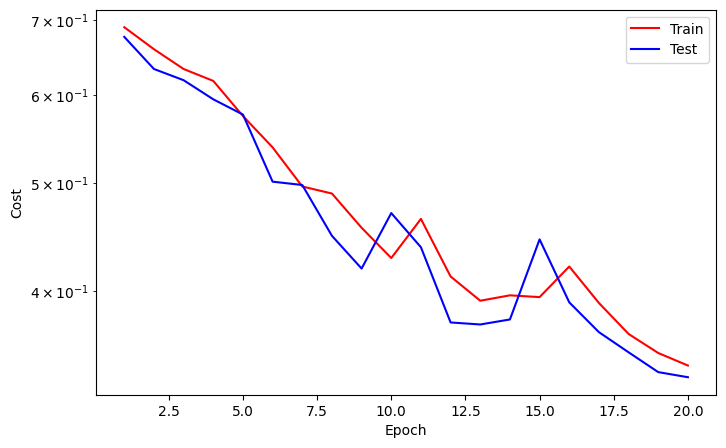

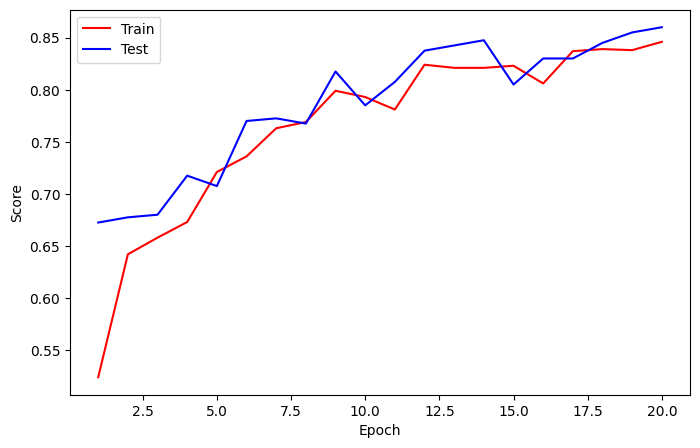

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.3441 | Test_cost  = 0.3415 | Train_score = 0.8560 | Test_score = 0.8575 |
==> EarlyStop patience =  1 | Best test_score: 0.8600


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>
self._shutdown_workers()
Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
            self._shutdown_workers()if w.is_alive():
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.3420 | Test_cost  = 0.3197 | Train_score = 0.8470 | Test_score = 0.8625 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.3331 | Test_cost  = 0.3283 | Train_score = 0.8610 | Test_score = 0.8750 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.3333 | Test_cost  = 0.3266 | Train_score = 0.8510 | Test_score = 0.8650 |
==> EarlyStop patience =  1 | Best test_score: 0.8750


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.3392 | Test_cost  = 0.3512 | Train_score = 0.8570 | Test_score = 0.8600 |
==> EarlyStop patience =  2 | Best test_score: 0.8750


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.3361 | Test_cost  = 0.3228 | Train_score = 0.8460 | Test_score = 0.8550 |
==> EarlyStop patience =  3 | Best test_score: 0.8750


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
if w.is_alive():
AssertionError  File "/usr/lib/python3.10/multiprocessing/proce

Train:   0%|          | 0/8 [00:00<?, ?it/s]

: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2398f8a950>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid 

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.3386 | Test_cost  = 0.3346 | Train_score = 0.8470 | Test_score = 0.8475 |
==> EarlyStop patience =  4 | Best test_score: 0.8750


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.3343 | Test_cost  = 0.3081 | Train_score = 0.8520 | Test_score = 0.8600 |
==> EarlyStop patience =  5 | Best test_score: 0.8750
==> Execute Early Stopping at epoch: 28 | Best test_score: 0.8750
==> Best model is saved at model


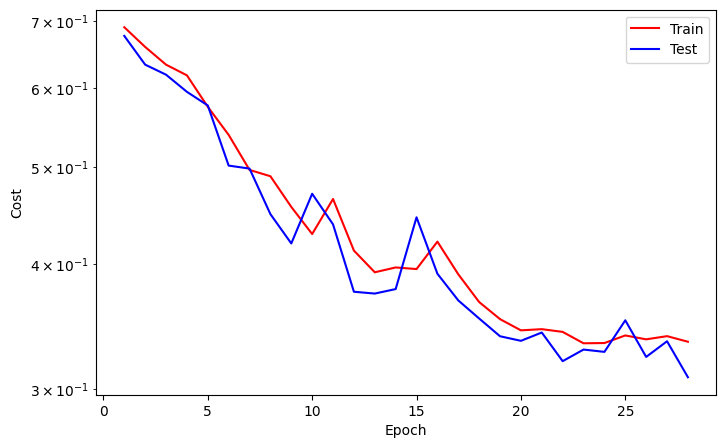

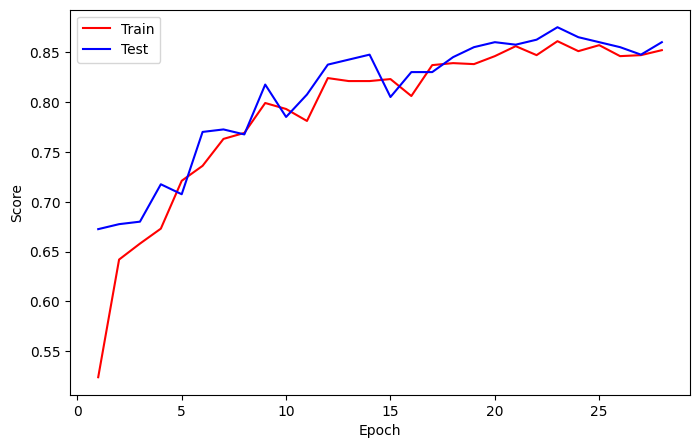

In [33]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
      test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  #Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

#Predict

In [34]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [35]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = output.argmax(1)
preds

tensor([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')

#Visualize

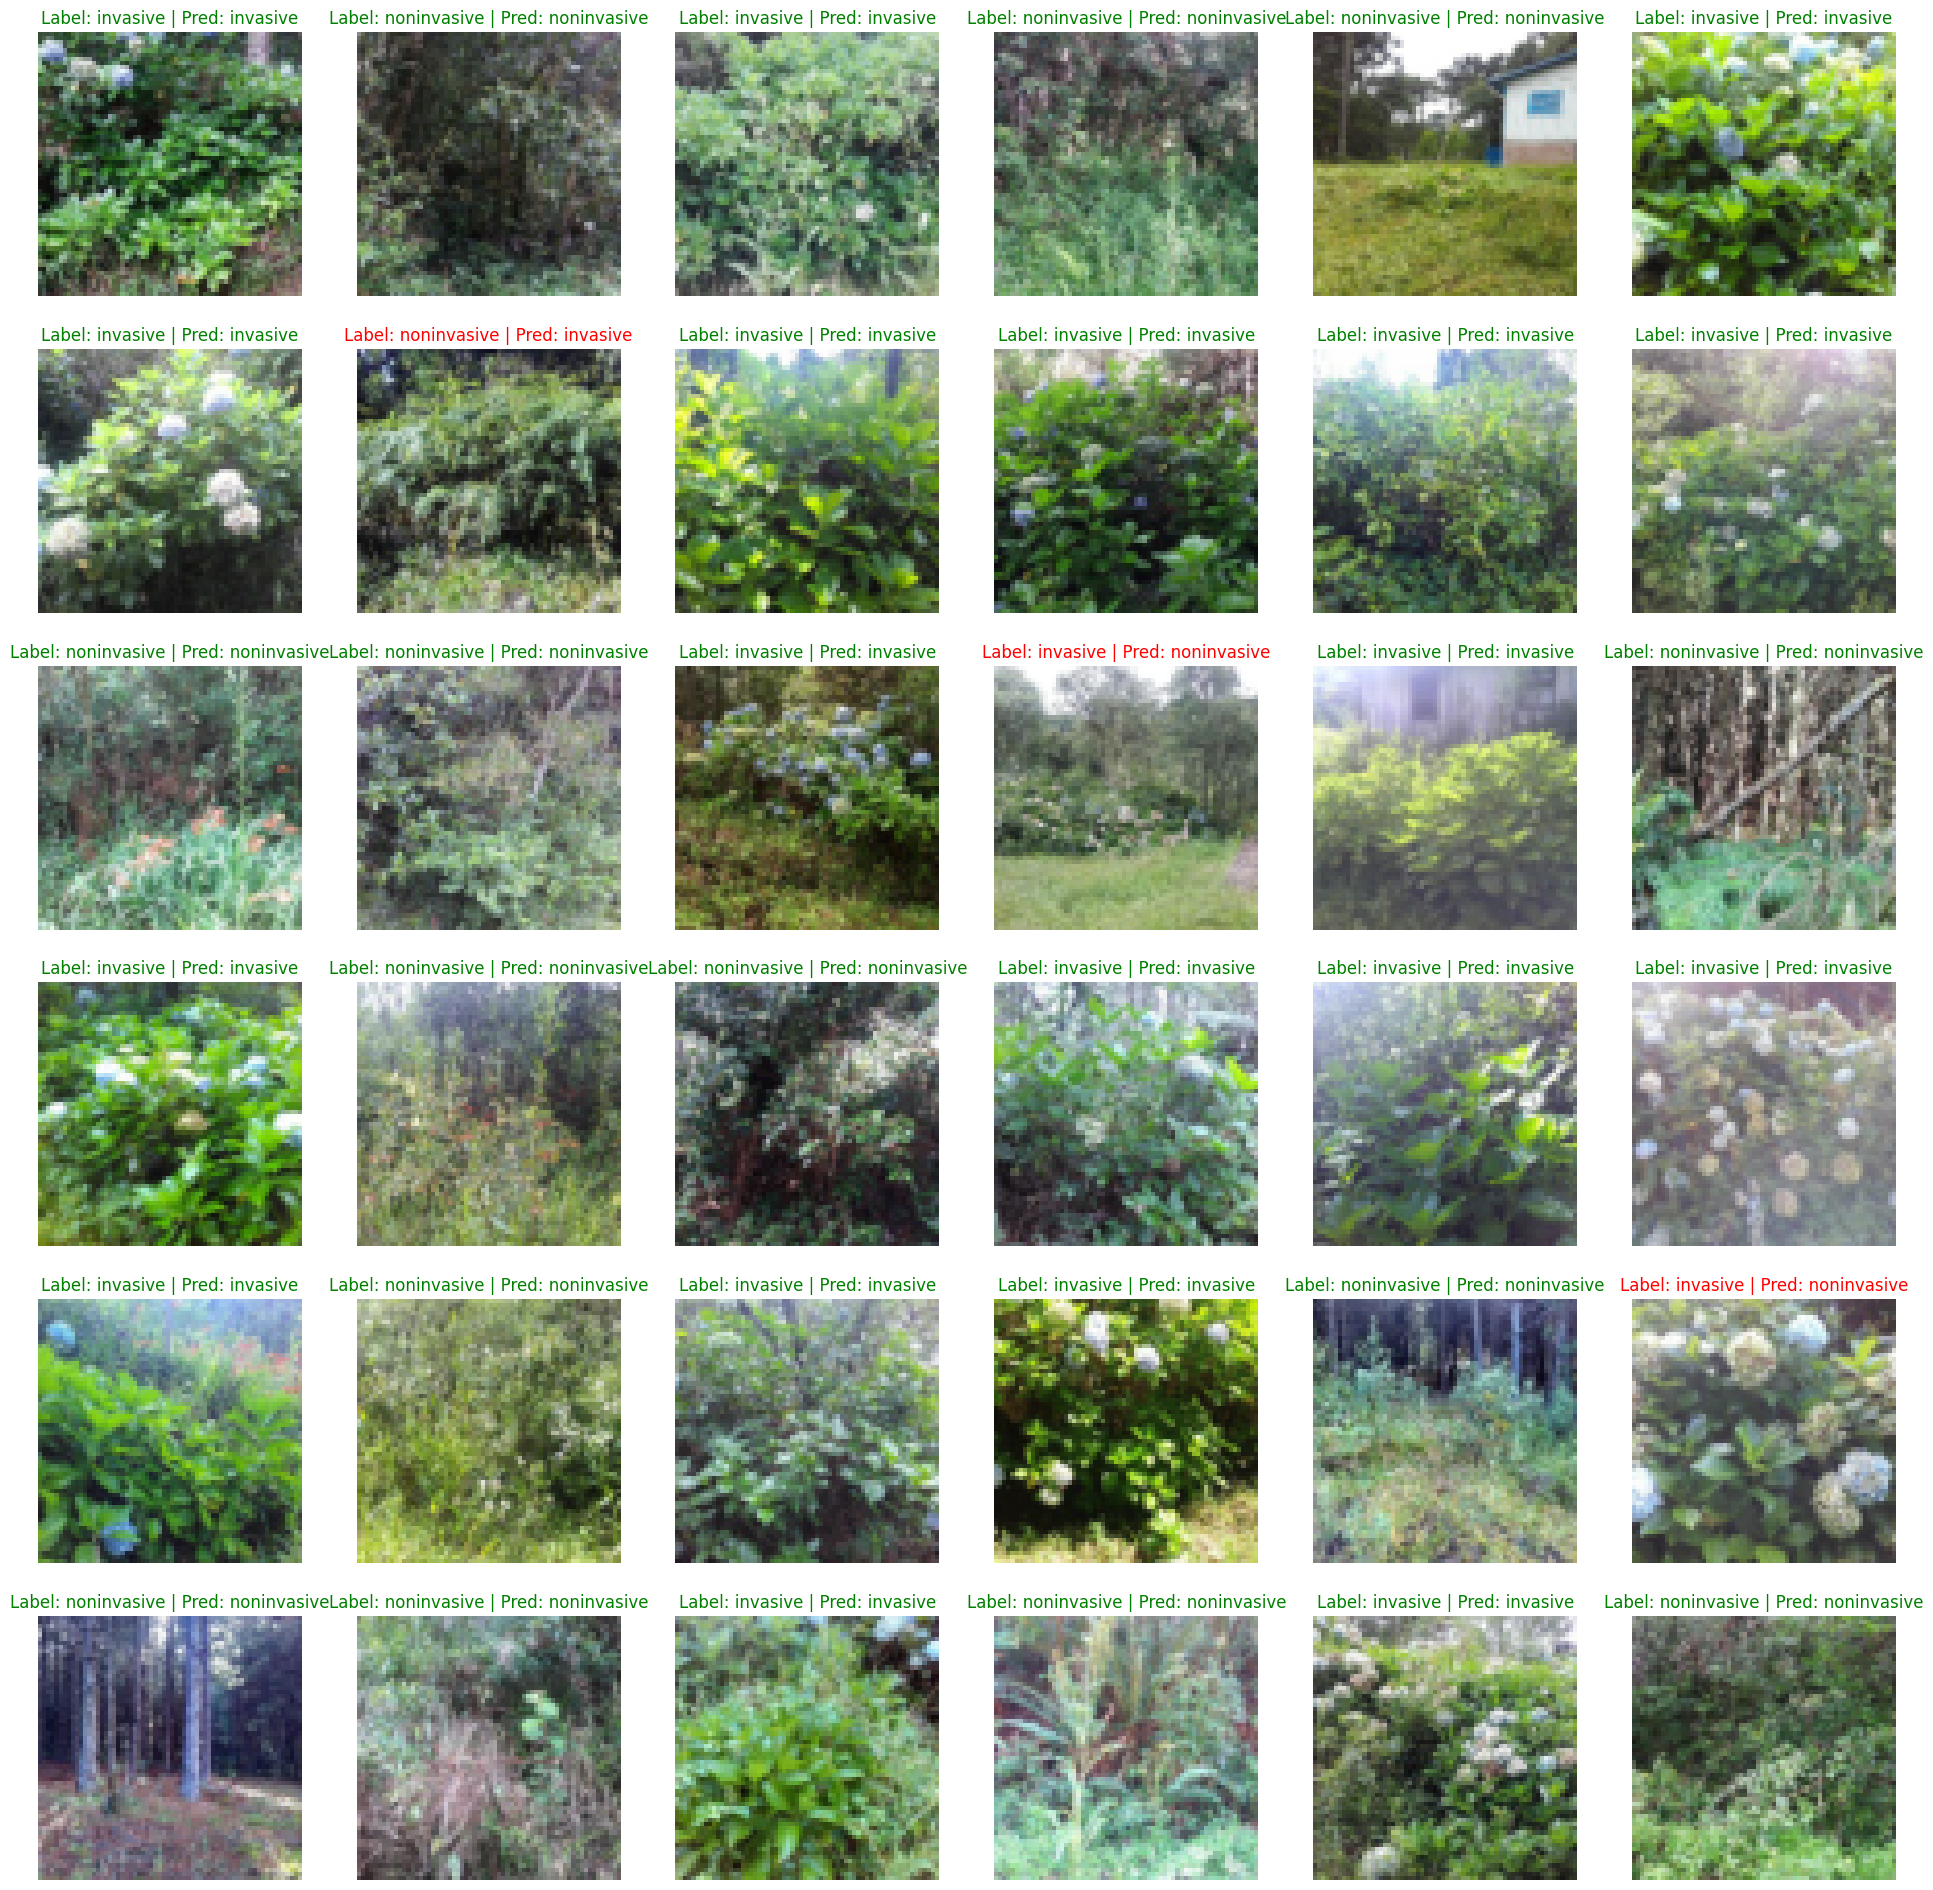

In [36]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {'color': 'r'} if label.item() != pred.item() else {'color': 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f'Label: {label} | Pred: {pred}', fontdict=font)
    ax.axis('off')

plt.show()
